In [1]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import random

from rfgap import RFGAP
from SupportFunctions.imbalancer import ImbalanceHandler


In [2]:
#- Load and preview the dataset

dataset_name = "chess"
imbalance_ratio = 0.1
ratio_smote = 0.2 # percent of points generated by SMOTE (the rest will be generated by proximity)
n_synthetic = 200 # for hybrid approach, total number of synthetic samples to generate
with open("prepared_datasets.pkl", "rb") as f:
    datasets = joblib.load(f)

data_entry = datasets[dataset_name]
categorical_indices = data_entry["categorical_indices"]
df = data_entry["data"]

print(f"{dataset_name}")
print(f"Shape of data: {df.shape}")
display(df.head())

chess
Shape of data: (3196, 37)


,outcome,0,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,33,34,35
0,won,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,t,t,n
1,won,f,f,f,f,t,f,f,f,f,...,f,f,f,f,f,f,f,t,t,n
2,won,f,f,f,f,t,f,t,f,f,...,f,f,f,f,f,f,f,t,t,n
3,won,f,f,f,f,f,f,f,f,t,...,f,f,f,f,f,f,f,t,t,n
4,won,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,t,t,n


In [3]:
# - Train Test Split and Categorical Encoding

# Separate features and target variable
target_col = df.columns[0]
X = df.drop(columns=[target_col])
y = df[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# Encode categorical features on training set
cat_columns = [X.columns[i] for i in categorical_indices]

# Store categories before encoding
train_categories = {}

# Convert train categorical columns to category dtype and save categories
for col in cat_columns:
    X_train[col] = X_train[col].astype("category")
    train_categories[col] = X_train[col].cat.categories

# Use train categories to encode train data
for col in cat_columns:
    X_train[col] = X_train[col].cat.codes

# Encode test set using train categories, unseen categories get code -1
for col in cat_columns:
    X_test[col] = pd.Categorical(X_test[col], categories=train_categories[col]).codes

In [4]:
#- Create a copy and introduce imbalance

# Create a copy of the original training data
X_train_full = X_train.copy()
y_train_full = y_train.copy()

imbalancer = ImbalanceHandler(X_train_full, y_train_full,
                              imbalance_ratio=imbalance_ratio,
                              batch_size=200,
                              random_state=42)

X_imb, y_imb = imbalancer.introduce_imbalance()

Original class distribution: {'won': 1168, 'nowin': 1069}
Imbalanced class distribution: {'won': 180, 'nowin': 20}


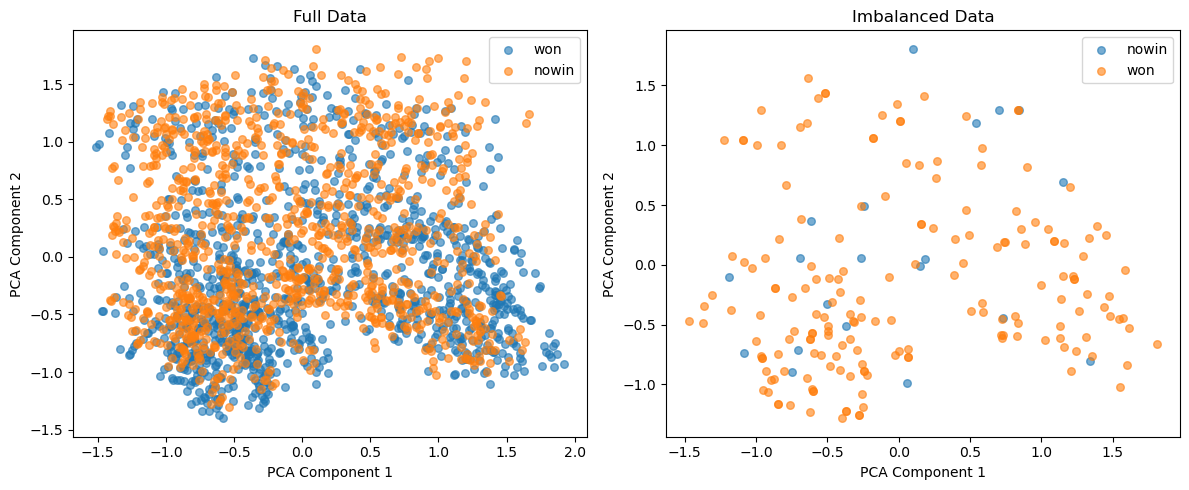

In [5]:
# Plot class distributions between imbalanced and full dataset
def plot_pca_scatter(X_full, y_full, X_imb, y_imb):
    pca = PCA(n_components=2)
    X_full_2d = pca.fit_transform(X_full)
    X_imb_2d = pca.transform(X_imb)

    fig, axs = plt.subplots(1, 2, figsize=(12,5))

    for ax, X_, y_, title in zip(axs, [X_full_2d, X_imb_2d], [y_full, y_imb], ['Full Data', 'Imbalanced Data']):
        classes = y_.unique()
        for cls in classes:
            mask = (y_ == cls)
            ax.scatter(X_[mask, 0], X_[mask, 1], label=cls, alpha=0.6, s=30)
        ax.set_title(title)
        ax.legend()
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
    plt.tight_layout()
    plt.show()

plot_pca_scatter(X_train_full, y_train_full, X_imb, y_imb)


In [6]:
#- Apply SMOTE to the imbalanced dataset
smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X_imb, y_imb)

print(f"Class distribution after SMOTE:\n{y_smote.value_counts()}")

Class distribution after SMOTE:
outcome
nowin    180
won      180
Name: count, dtype: int64


In [7]:
# - Hybrid Approach: SMOTE + Proximity-guided Samples

# The approach splits the load of generating synthetic samples between SMOTE and a proximity-guided method. 
# This aims to gather the benefits of both methods while avoiding the drawbacks of each when used alone.

# Number of synthetic samples total and ratio for SMOTE part
n_smote = int(n_synthetic * ratio_smote)
n_prox = n_synthetic - n_smote

minority_class = y_imb.value_counts().idxmin()
X_minority = X_imb[y_imb == minority_class]

# --- SMOTE Synthetic Samples ---
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_imb, y_imb)

# Extract only the synthetic samples generated by SMOTE
n_original = len(X_imb)
synthetic_mask = np.arange(len(X_smote)) >= n_original
X_synthetic_smote_all = pd.DataFrame(X_smote[synthetic_mask], columns=X_imb.columns)

# Sample n_smote synthetic samples randomly from SMOTE results
if len(X_synthetic_smote_all) > n_smote:
    chosen_indices = np.random.choice(len(X_synthetic_smote_all), size=n_smote, replace=False)
    X_synthetic_smote = X_synthetic_smote_all.iloc[chosen_indices].to_numpy()
else:
    X_synthetic_smote = X_synthetic_smote_all.to_numpy()

# --- Proximity-guided Synthetic Samples ---
rfgap = RFGAP(n_estimators=100, random_state=42)
rfgap.fit(X_minority, y_imb[y_imb == minority_class])
prox_matrix = rfgap.get_proximities()

if hasattr(prox_matrix, "toarray"):
    prox_matrix = prox_matrix.toarray()

k_neighbors = 5
neighbors_idx = np.argsort(prox_matrix, axis=1)[:, -k_neighbors-1:-1]

synthetic_samples_prox = []
for _ in range(n_prox):
    i = np.random.choice(len(X_minority))
    base = X_minority.iloc[i].values
    neighbor_indices = neighbors_idx[i]
    neighbor_prox = prox_matrix[i, neighbor_indices]
    weights = neighbor_prox / neighbor_prox.sum() if neighbor_prox.sum() > 0 else np.ones_like(neighbor_prox) / len(neighbor_prox)
    chosen_neighbor_idx = np.random.choice(neighbor_indices, p=weights)
    neighbor = X_minority.iloc[chosen_neighbor_idx].values
    alpha = np.random.rand()
    synthetic = base + alpha * (neighbor - base)
    synthetic_samples_prox.append(synthetic)

synthetic_array_prox = np.array(synthetic_samples_prox)

# --- Combine all into hybrid dataset ---
X_aug = pd.concat([
    X_imb,
    pd.DataFrame(X_synthetic_smote, columns=X_imb.columns),
    pd.DataFrame(synthetic_array_prox, columns=X_imb.columns)
], ignore_index=True)

y_aug = pd.concat([
    y_imb,
    pd.Series([minority_class] * len(X_synthetic_smote)),
    pd.Series([minority_class] * len(synthetic_samples_prox))
], ignore_index=True)

print(f"Hybrid dataset size: {X_aug.shape}, {y_aug.shape}")
print(f"Class distribution in hybrid data:\n{y_aug.value_counts()}")


Hybrid dataset size: (400, 36), (400,)
Class distribution in hybrid data:
nowin    220
won      180
Name: count, dtype: int64


In [8]:
def train_and_evaluate(X_train, y_train, X_test, y_test, label):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    # Use weighted average to account for class imbalance
    f1 = f1_score(y_test, preds, average='weighted')
    print(f"[F1 - {label}] Weighted F1 Score: {f1:.4f}")
    return f1

results = {}

results['Baseline'] = train_and_evaluate(X_train_full, y_train_full, X_test, y_test, "Baseline")
results['Unbalanced'] = train_and_evaluate(X_imb, y_imb, X_test, y_test, "Unbalanced")
results['SMOTE'] = train_and_evaluate(X_smote, y_smote, X_test, y_test, "SMOTE")
results['Hybrid'] = train_and_evaluate(X_aug, y_aug, X_test, y_test, "Hybrid")


[F1 - Baseline] Weighted F1 Score: 0.9896
[F1 - Unbalanced] Weighted F1 Score: 0.7217
[F1 - SMOTE] Weighted F1 Score: 0.7881
[F1 - Hybrid] Weighted F1 Score: 0.8564


In [9]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, label):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    f1 = f1_score(y_test, preds, average='weighted')
    print(f"[F1 - {label}] Weighted F1 Score: {f1:.4f}")
    return f1

def run_experiment(seed, n_synthetic=100, ratio_smote=0.5, k_neighbors=5, dataset_name="chess", imbalance_ratio=0.05):
    
    random.seed(seed)
    np.random.seed(seed)

    # Load datasets from pickle
    with open("prepared_datasets.pkl", "rb") as f:
        datasets = joblib.load(f)

    data_entry = datasets[dataset_name]
    df = data_entry["data"]
    categorical_indices = data_entry["categorical_indices"]
    target_col = df.columns[0]

    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Train-test split with stratification
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=seed)

    # Encode categorical features
    cat_columns = [X.columns[i] for i in categorical_indices]

    # Save train categories before encoding
    train_categories = {}
    for col in cat_columns:
        X_train_full[col] = X_train_full[col].astype("category")
        train_categories[col] = X_train_full[col].cat.categories

    for col in cat_columns:
        X_train_full[col] = X_train_full[col].cat.codes

    for col in cat_columns:
        X_test[col] = pd.Categorical(X_test[col], categories=train_categories[col]).codes

    # Introduce imbalance
    imbalancer = ImbalanceHandler(X_train_full, y_train_full,
                                  imbalance_ratio=imbalance_ratio,
                                  batch_size=200,
                                  random_state=seed)
    X_imb, y_imb = imbalancer.introduce_imbalance()

    # SMOTE oversampling
    n_smote = int(n_synthetic * ratio_smote)
    n_prox = n_synthetic - n_smote

    minority_class = y_imb.value_counts().idxmin()
    X_minority = X_imb[y_imb == minority_class]

    sm = SMOTE(random_state=seed)
    X_smote_all, y_smote_all = sm.fit_resample(X_imb, y_imb)

    n_original = len(X_imb)
    synthetic_mask = np.arange(len(X_smote_all)) >= n_original
    X_synthetic_smote_all = pd.DataFrame(X_smote_all[synthetic_mask], columns=X_imb.columns)

    if len(X_synthetic_smote_all) > n_smote:
        chosen_indices = np.random.choice(len(X_synthetic_smote_all), size=n_smote, replace=False)
        X_synthetic_smote = X_synthetic_smote_all.iloc[chosen_indices].to_numpy()
    else:
        X_synthetic_smote = X_synthetic_smote_all.to_numpy()

    # Proximity-guided synthetic sampling
    rfgap = RFGAP(n_estimators=100, random_state=seed)
    rfgap.fit(X_minority, y_imb[y_imb == minority_class])
    prox_matrix = rfgap.get_proximities()

    if hasattr(prox_matrix, "toarray"):
        prox_matrix = prox_matrix.toarray()

    neighbors_idx = np.argsort(prox_matrix, axis=1)[:, -k_neighbors-1:-1]

    synthetic_samples_prox = []
    for _ in range(n_prox):
        i = np.random.choice(len(X_minority))
        base = X_minority.iloc[i].values
        neighbor_indices = neighbors_idx[i]
        neighbor_prox = prox_matrix[i, neighbor_indices]
        weights = neighbor_prox / neighbor_prox.sum() if neighbor_prox.sum() > 0 else np.ones_like(neighbor_prox) / len(neighbor_prox)
        chosen_neighbor_idx = np.random.choice(neighbor_indices, p=weights)
        neighbor = X_minority.iloc[chosen_neighbor_idx].values
        alpha = np.random.rand()
        synthetic = base + alpha * (neighbor - base)
        synthetic_samples_prox.append(synthetic)

    synthetic_array_prox = np.array(synthetic_samples_prox)

    # Proximity-only dataset: imbalanced + proximity synthetic samples only
    X_prox = pd.concat([
        X_imb,
        pd.DataFrame(synthetic_array_prox, columns=X_imb.columns)
    ], ignore_index=True)

    y_prox = pd.concat([
        y_imb,
        pd.Series([minority_class] * len(synthetic_samples_prox))
    ], ignore_index=True)

    # Hybrid dataset: imbalanced + SMOTE + proximity synthetic samples
    X_aug = pd.concat([
        X_imb,
        pd.DataFrame(X_synthetic_smote, columns=X_imb.columns),
        pd.DataFrame(synthetic_array_prox, columns=X_imb.columns)
    ], ignore_index=True)

    y_aug = pd.concat([
        y_imb,
        pd.Series([minority_class] * len(X_synthetic_smote)),
        pd.Series([minority_class] * len(synthetic_samples_prox))
    ], ignore_index=True)

    # Train and evaluate on all datasets
    results = {}
    results['Baseline'] = train_and_evaluate_rf(X_train_full, y_train_full, X_test, y_test, "Baseline (Full Data)")
    results['Unbalanced'] = train_and_evaluate_rf(X_imb, y_imb, X_test, y_test, "Unbalanced")
    results['SMOTE'] = train_and_evaluate_rf(pd.DataFrame(X_smote_all, columns=X_imb.columns), y_smote_all, X_test, y_test, "SMOTE Only")
    results['Proximity'] = train_and_evaluate_rf(X_prox, y_prox, X_test, y_test, "Proximity Only")
    results['Hybrid'] = train_and_evaluate_rf(X_aug, y_aug, X_test, y_test, "Hybrid SMOTE + Proximity")

    return results


In [14]:
random.seed(45)
seeds = random.sample(range(1, 10000), 5)
print(seeds)

[4455, 6844, 7996, 4222, 1342]


In [13]:
results = run_experiment(seed=46, ratio_smote=0.5, imbalance_ratio=0.2, dataset_name="chess")

Original class distribution: {'won': 1168, 'nowin': 1069}
Imbalanced class distribution: {'won': 160, 'nowin': 40}
[F1 - Baseline (Full Data)] Weighted F1 Score: 0.9906
[F1 - Unbalanced] Weighted F1 Score: 0.8193
[F1 - SMOTE Only] Weighted F1 Score: 0.8192
[F1 - Proximity Only] Weighted F1 Score: 0.7951
[F1 - Hybrid SMOTE + Proximity] Weighted F1 Score: 0.8166


In [ ]:
# Testing 

results_all = {
    'Baseline': [],
    'Unbalanced': [],
    'SMOTE': [],
    'Proximity': [],
    'Hybrid': []
}

for seed in seeds:
    print(f"\nRunning experiment for seed {seed}")
    result = run_experiment(seed=seed, ratio_smote=0.5, imbalance_ratio=0.1, dataset_name="titanic")
    for key in results_all.keys():
        results_all[key].append(result.get(key, np.nan))

print("\nSummary of weighted F1 scores over all seeds:")
for method, scores in results_all.items():
    mean_score = np.nanmean(scores)
    std_score = np.nanstd(scores)
    print(f"{method}: {mean_score:.4f} ± {std_score:.4f}")



Running experiment for seed 4455
Original class distribution: {0: 297, 1: 201}
Imbalanced class distribution: {0: 180, 1: 20}
[F1 - Baseline (Full Data)] Weighted F1 Score: 0.7781
[F1 - Unbalanced] Weighted F1 Score: 0.6784
[F1 - SMOTE Only] Weighted F1 Score: 0.7641
[F1 - Proximity Only] Weighted F1 Score: 0.7458
[F1 - Hybrid SMOTE + Proximity] Weighted F1 Score: 0.7664

Running experiment for seed 6844
Original class distribution: {0: 297, 1: 201}
Imbalanced class distribution: {0: 180, 1: 20}
[F1 - Baseline (Full Data)] Weighted F1 Score: 0.8020
[F1 - Unbalanced] Weighted F1 Score: 0.6824
[F1 - SMOTE Only] Weighted F1 Score: 0.7602
[F1 - Proximity Only] Weighted F1 Score: 0.7280
[F1 - Hybrid SMOTE + Proximity] Weighted F1 Score: 0.7516

Running experiment for seed 7996
Original class distribution: {0: 297, 1: 201}
Imbalanced class distribution: {0: 180, 1: 20}
[F1 - Baseline (Full Data)] Weighted F1 Score: 0.7753
[F1 - Unbalanced] Weighted F1 Score: 0.7356
[F1 - SMOTE Only] Weighte

In [ ]:
def summarize_and_append_results(results_all, dataset_name, ratio_smote, imbalance_ratio, seed_count, results_df=None):
    """
    results_all: dict of lists with raw scores per seed for each method
    dataset_name, ratio_smote, imbalance_ratio, seed_count: experiment params
    results_df: optional existing DataFrame to append to
    
    Returns updated DataFrame with new summarized rows appended.
    """
    rows = []
    for method, scores in results_all.items():
        scores_array = np.array(scores)
        mean_score = np.nanmean(scores_array)
        std_score = np.nanstd(scores_array)
        std_error = std_score / np.sqrt(seed_count) if seed_count > 0 else np.nan
        rows.append({
            "Dataset": dataset_name,
            "Method": method,
            "Mean": mean_score,
            "Standard_Error": std_error,
            "Ratio_SMOTE": ratio_smote,
            "Imbalance_Ratio": imbalance_ratio,
            "Seed_Count": seed_count
        })

    df_new = pd.DataFrame(rows)

    if results_df is not None:
        results_df = pd.concat([results_df, df_new], ignore_index=True)
    else:
        results_df = df_new

    return results_df

dataset_name = "wine"
ratio_smote = 0.5
imbalance_ratio = 0.05
seed_count = len(seeds)

results_df = summarize_and_append_results(results_all, dataset_name, ratio_smote, imbalance_ratio, seed_count)

print(results_df)


  Dataset      Method      Mean  Standard_Error  Ratio_SMOTE  Imbalance_Ratio  \
0    wine    Baseline  0.985200        0.003309          0.5             0.05   
1    wine  Unbalanced  0.988913        0.004048          0.5             0.05   
2    wine       SMOTE  0.981552        0.005205          0.5             0.05   
3    wine   Proximity  0.977853        0.003278          0.5             0.05   
4    wine      Hybrid  0.981552        0.005205          0.5             0.05   

   Seed_Count  
0           5  
1           5  
2           5  
3           5  
4           5  


In [ ]:
# combined_results = results_df.copy()

# excluded due to complication: flare1, mnist_test, optdigits, segmentation, treeData, zoo

In [ ]:
combined_results = pd.concat([combined_results, results_df], ignore_index=True).drop_duplicates()
combined_results

,Dataset,Method,Mean,Standard_Error,Ratio_SMOTE,Imbalance_Ratio,Seed_Count
0,ecoli_5,Baseline,0.880235,0.006428,0.5,0.05,5
1,ecoli_5,Unbalanced,0.842143,0.020633,0.5,0.05,5
2,ecoli_5,SMOTE,0.835749,0.021962,0.5,0.05,5
3,ecoli_5,Proximity,0.835583,0.017819,0.5,0.05,5
4,ecoli_5,Hybrid,0.853134,0.020733,0.5,0.05,5
...,...,...,...,...,...,...,...
75,wine,Baseline,0.985200,0.003309,0.5,0.05,5
76,wine,Unbalanced,0.988913,0.004048,0.5,0.05,5
77,wine,SMOTE,0.981552,0.005205,0.5,0.05,5
78,wine,Proximity,0.977853,0.003278,0.5,0.05,5


In [ ]:
combined_results = combined_results.iloc[:-5]

In [ ]:
# combined_results.to_csv("combined_results.csv", index=False)